In [30]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt

print(f"OpenCV version: {cv.__version__}")
print(f"Tensorflow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

OpenCV version: 3.4.2
Tensorflow version: 1.14.0
NumPy version: 1.15.4


In [31]:
class DigitRecognizer:
    def __init__(self):
        self._is_model_trained = False
        self._num_digits = 10
        self._model = self._build_model()

    def _build_model(self):
        # model and training taken from https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(self._num_digits, activation='softmax')
        ])
        
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=["accuracy"])
        
        model.summary()
    
        return model
    def _load_data(self):
        mnist_dataset = tf.keras.datasets.mnist
        (x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
        x_train, x_test = x_train.astype(np.float64) / 255.0, x_test.astype(np.float64) / 255.0
        x_train = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
        x_test = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))
        y_train_cat = tf.keras.utils.to_categorical(y_train, self._num_digits)
        y_test_cat = tf.keras.utils.to_categorical(y_test, self._num_digits)
        return x_train, y_train_cat, x_test, y_test_cat

    def train_model(self, epochs):
        x, y, _, _ = self._load_data()
        self._model.fit(x, y, epochs=epochs)
        self._is_model_trained = True

    def evaluate_model(self):
        if not self._is_model_trained:
            print("Model wasn't trained!!! Either train model or load stored weights!!!")
            return

        _, _, x_test, y_test = self._load_data()
        loss, acc = self._model.evaluate(x_test, y_test, verbose=0)
        print(f"loss: {loss}, accuracy: {acc}")

    def save_weights(self, filename='../model/digit_recognizer_weights.hdf5'):
        if not self._is_model_trained:
            print("I can't save model since it wasn't trained!")
            return
        self._model.save_weights(filename)
        print(f"Model was saved in {filename}")
    
    def load_weights(self, filename='../model/digit_recognizer_weights.hdf5'):
        self._model.load_weights(filename)
        self._is_model_trained = True
        print(f"Weights for model were loaded from: {filename}")

    def predict(self, digit_image):
        return np.argmax(self._model.predict(digit_image))

In [27]:
def predict_and_print_nicely(digit_recognizer):
    image_dir = "../input_images/"
    num_rows = 9
    num_columns = 5
    single_box_image_names = (image for image in os.listdir(image_dir) if image.startswith("SingleBox"))
    _, ax = plt.subplots(num_rows, num_columns, figsize=(28, 28), gridspec_kw={'hspace':0.1})
    for row in range(num_rows):
        for col in range(num_columns):
            images = []
            single_box_image_name = next(single_box_image_names)
            ax[row, col].axis("off")
            image_gray = cv.imread(image_dir + single_box_image_name, cv.IMREAD_GRAYSCALE)
            image = cv.resize(image_gray, (28, 28), interpolation=cv.INTER_AREA).reshape(28, 28, 1).astype('float32') / 255.0
            images.append(image)
            prediction = np.argmax(digit_recognizer._model.predict(np.array(images)), axis=1)
            ax[row, col].imshow(image_gray, cmap="gray")
            ax[row, col].set_title(f"{single_box_image_name} == {prediction}")
    plt.show()
    plt.close()

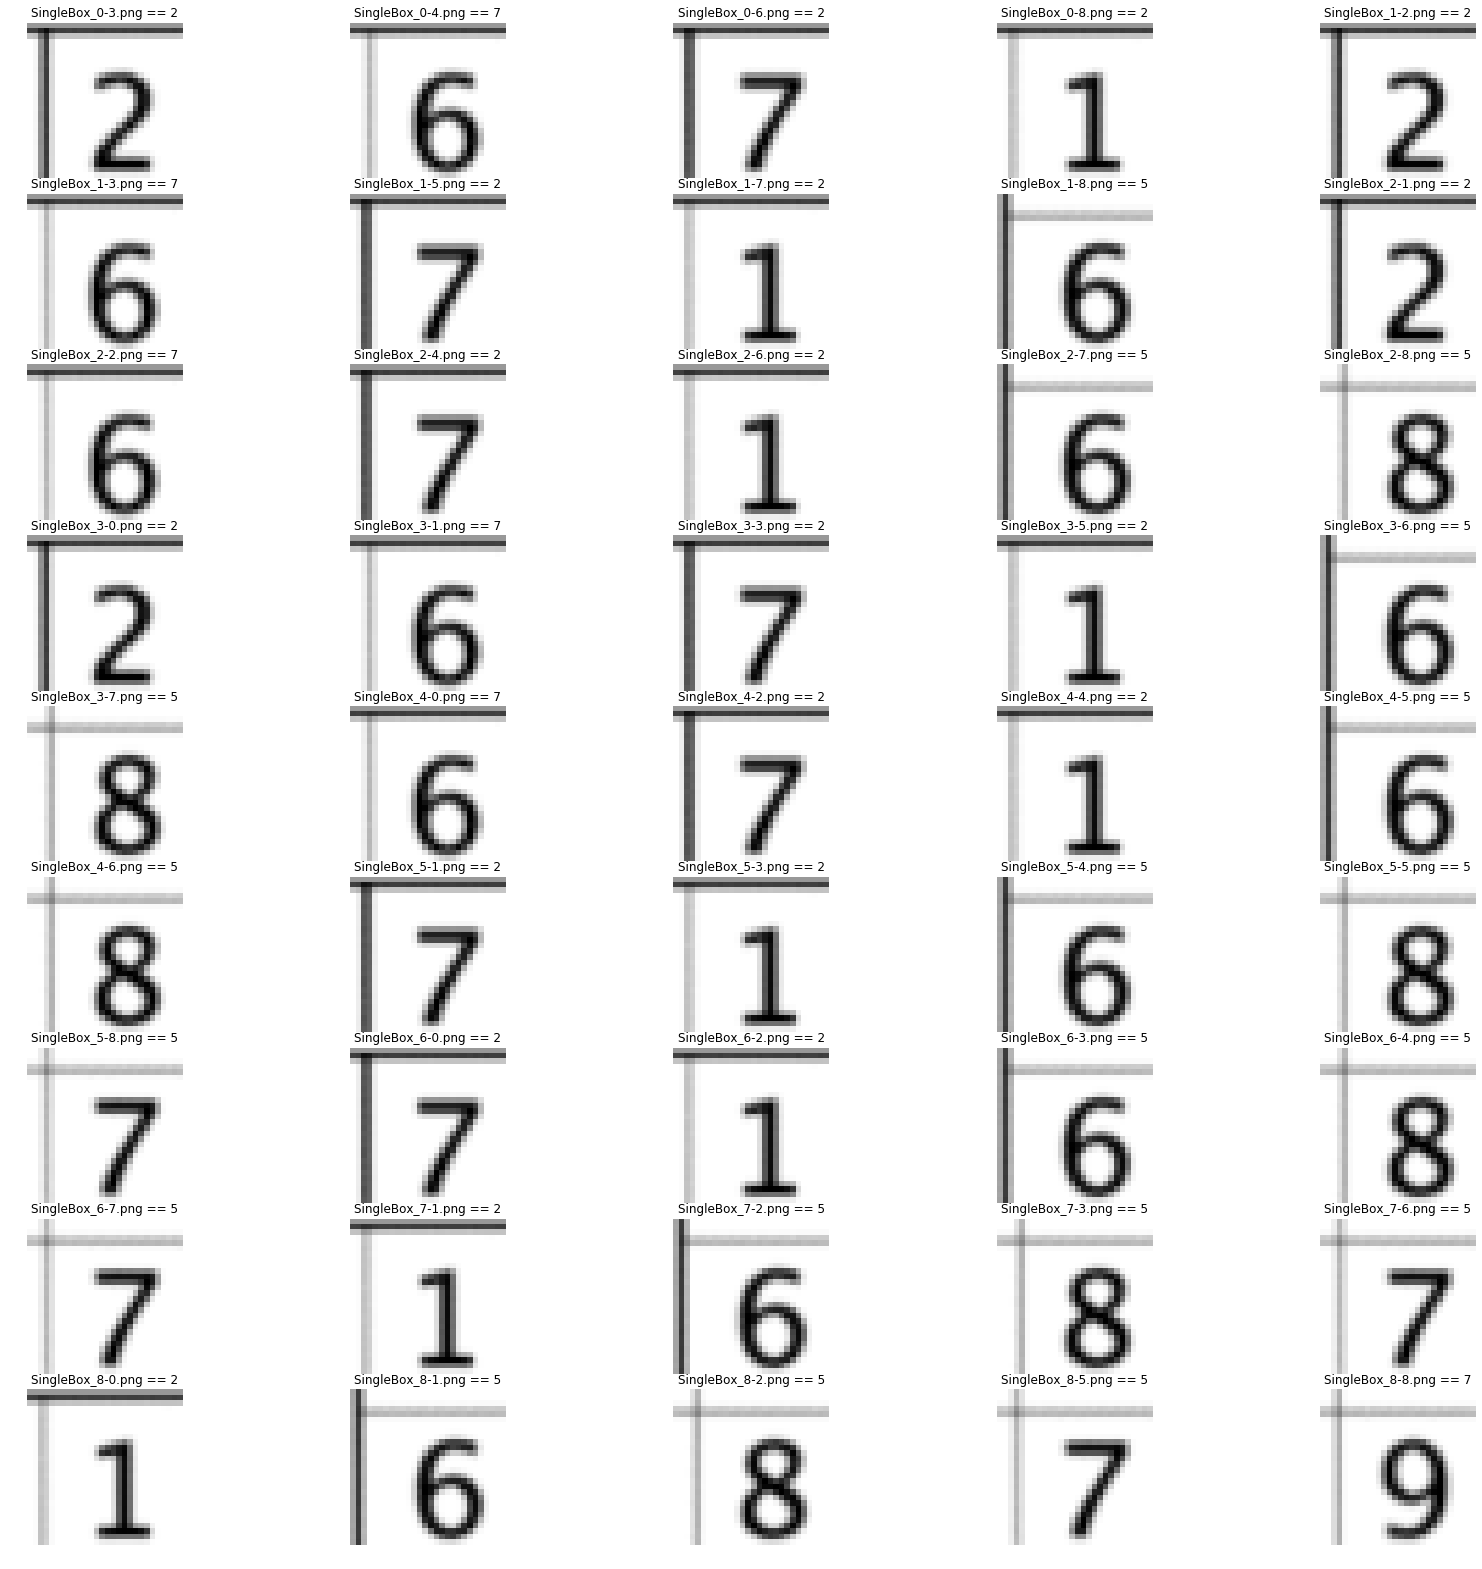

In [24]:
predict_and_print_nicely(new_recognizer)

In [15]:
new_recognizer2 = DigitRecognizer()
new_recognizer2.train_model(15)
new_recognizer2.evaluate_model()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 576)              

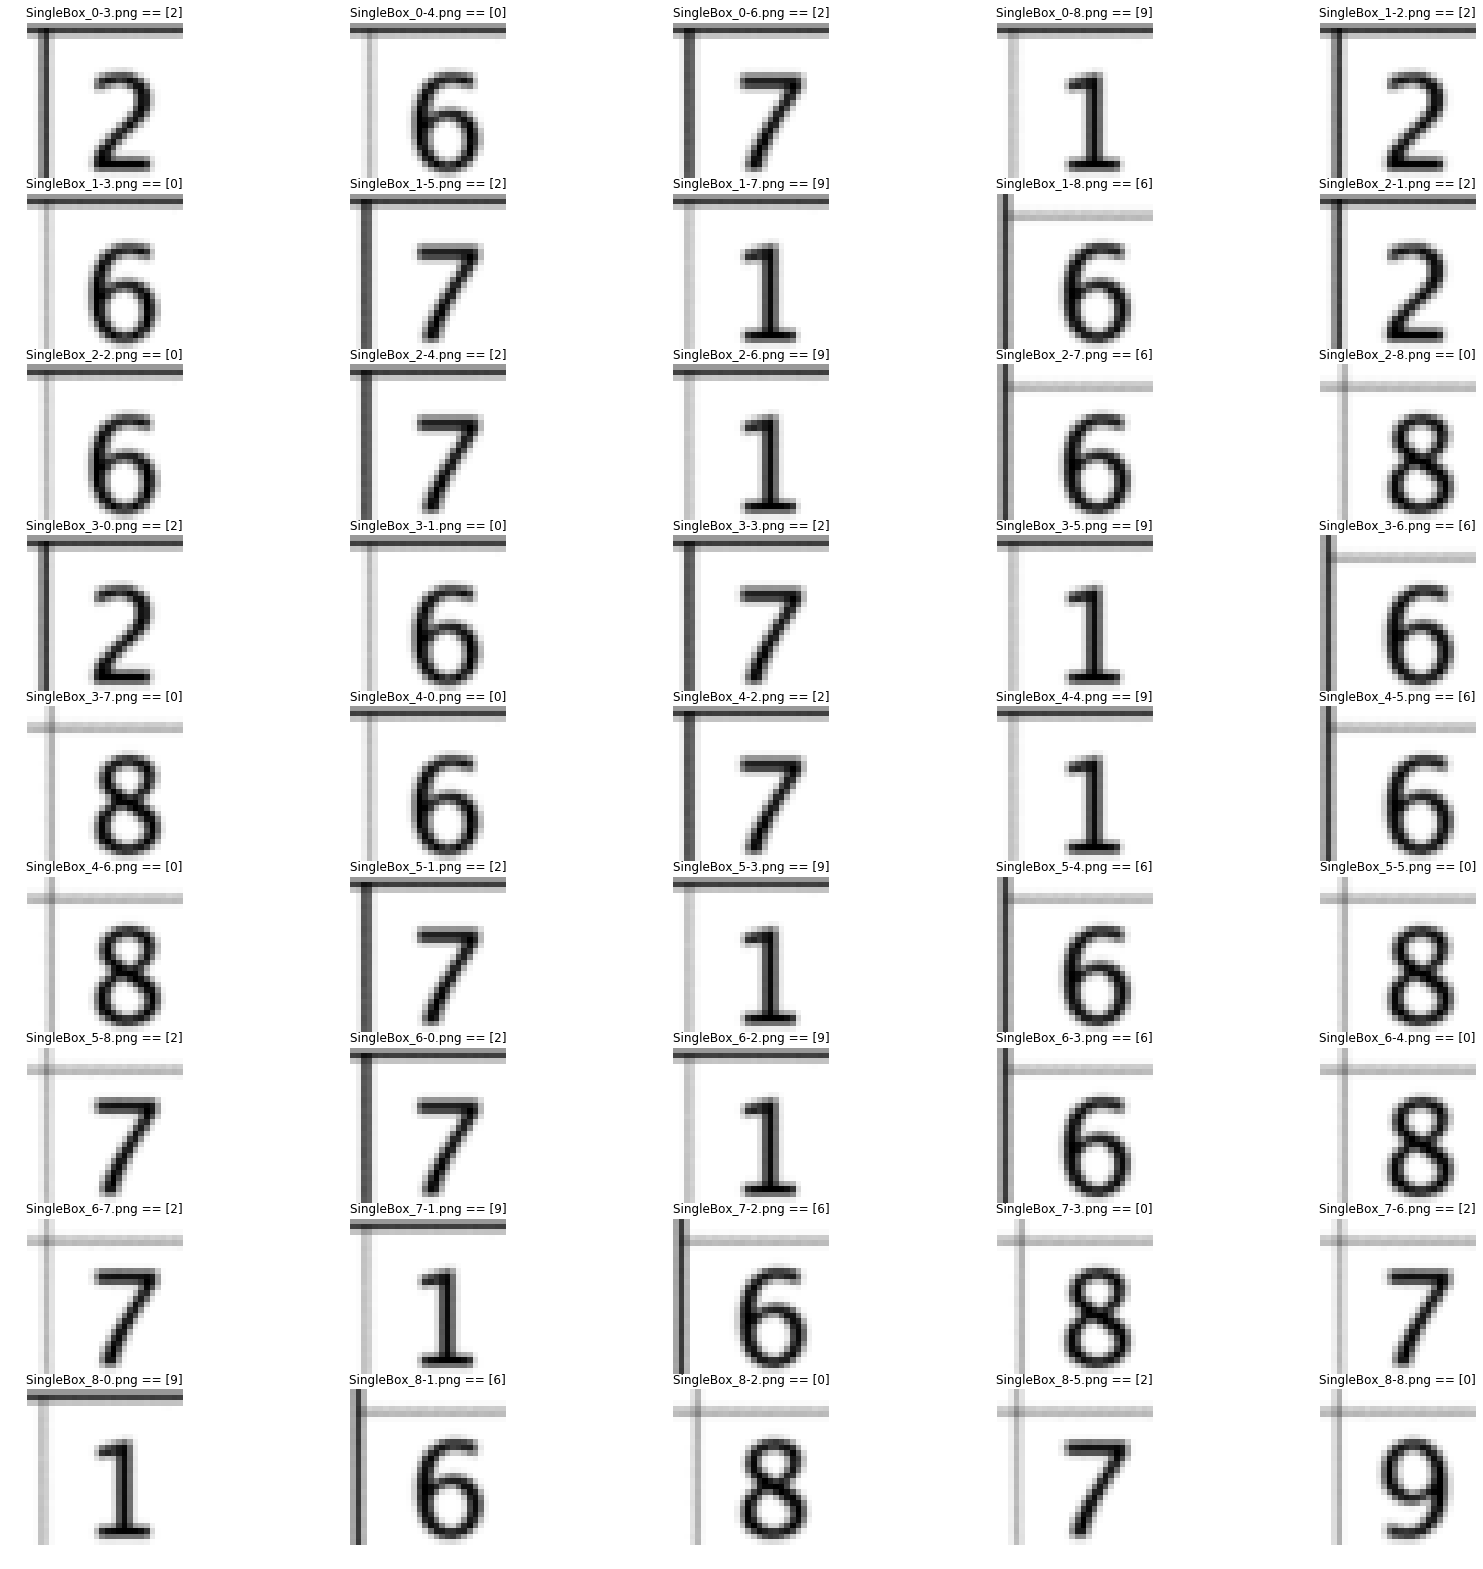

In [28]:
predict_and_print_nicely(new_recognizer2)